In [20]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
from utils.ccf_utils import ccf_pts_convert_to_mm
from utils.combine_tools import apply_qc
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import r2_score
import warnings
from scipy.stats import gaussian_kde
import trimesh
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from utils.ccf_utils import ccf_pts_convert_to_mm
from trimesh import load_mesh
from scipy.stats import pearsonr
warnings.filterwarnings('ignore')

%matplotlib inline

In [21]:
criteria_name = 'beh_all_NP'
metrics_folder = f'/root/capsule/code/beh_ephys_analysis/session_combine/metrics/{criteria_name}'
os.makedirs(metrics_folder, exist_ok=True)


In [22]:
# load constraints and data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)
    
with open(os.path.join('/root/capsule/code/beh_ephys_analysis/session_combine/metrics', f'{criteria_name}.json'), 'r') as f:
    constraints = json.load(f)
beh_folder = os.path.join('/root/capsule/scratch/combined/beh_plots', criteria_name)
if not os.path.exists(beh_folder):
    os.makedirs(beh_folder)
# start with a mask of all True
mask = pd.Series(True, index=combined_tagged_units.index)

Applying bounds for isi_violations: [0.0, 0.1]
 - isi_violations: 17847 -> 8148 units passed
Applying items for qc_pass: [True]
 - qc_pass: 8148 -> 5771 units passed
Applying bounds for peak: [-1000, 500]
 - peak: 5771 -> 5748 units passed
Applying bounds for trial_count: [100, 2000]
 - trial_count: 5748 -> 4224 units passed
Applying items for in_df: [True]
 - in_df: 4224 -> 4224 units passed
Applying items for probe: ['2']
 - probe: 4224 -> 4050 units passed
Applying bounds for y_loc: [0, 2000]
 - y_loc: 4050 -> 2796 units passed
Applying opto conditions: ['p_max', 'eu', 'corr', 'tag_loc', 'lat_max_p', 'p_mean', 'sig_counts']
Number of opto units after filtering: 153
Number of non-opto units after filtering: 2796


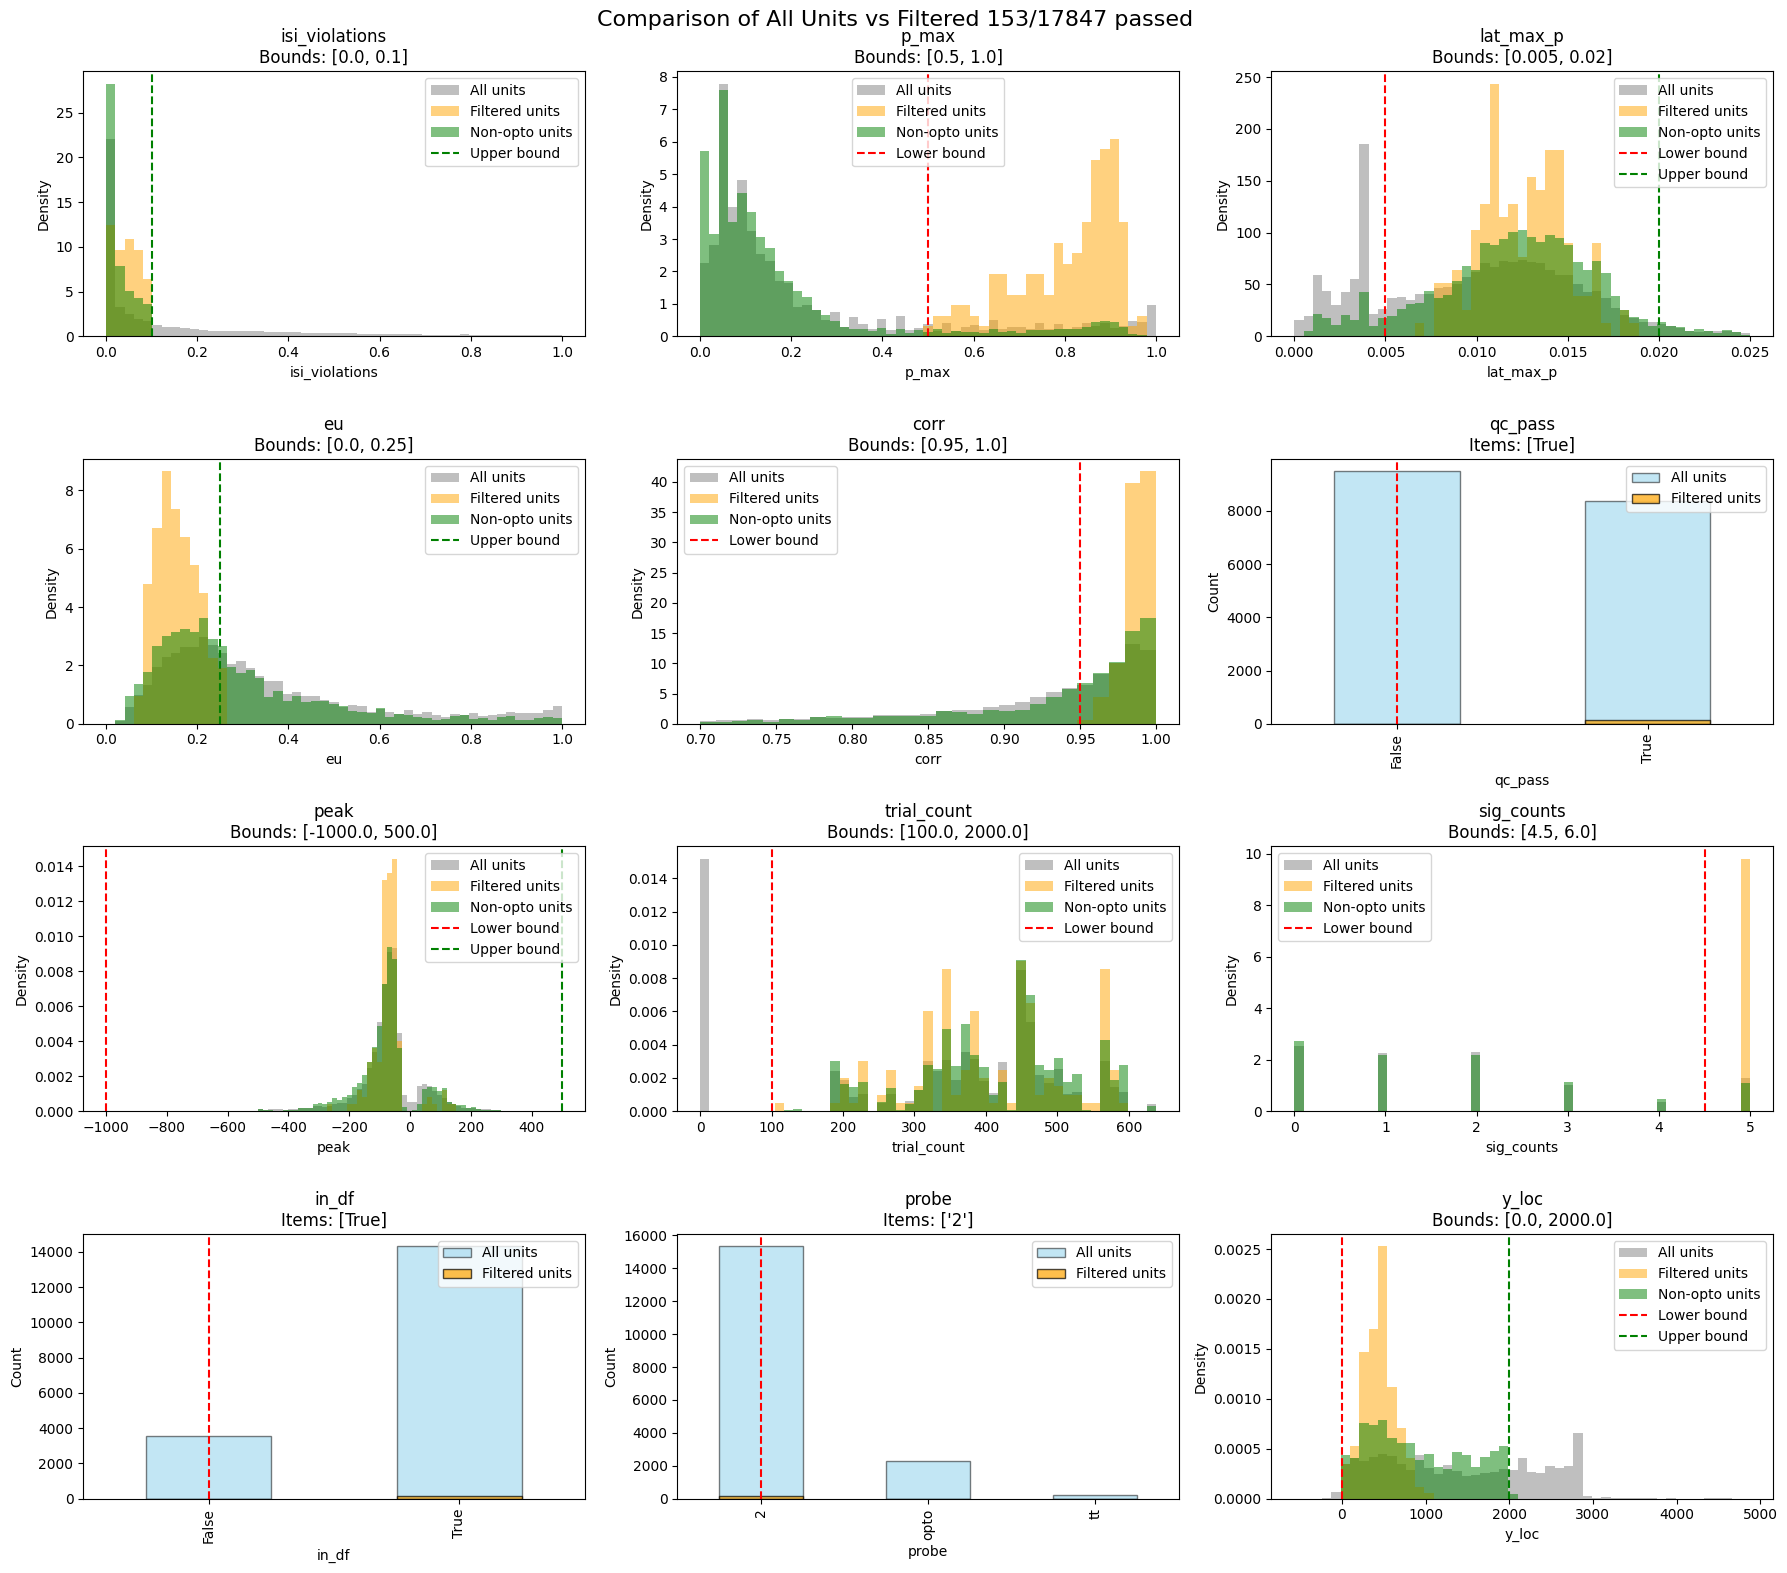

In [23]:
combined_tagged_units_filtered, combined_tagged_units, fig = apply_qc(combined_tagged_units, constraints)

In [24]:
# perform auc on sliding window and define best window for each unit
pre_event = -0.5
post_event = 2
binSize = 1.0
stepSize = 0.2
auc_mat = []           
auc_max = []
auc_max_ind = []
labels = ['outcome', 'ipsi']
loaded_session = None
curr_session = None
data_type = 'curated'
model_name = 'stan_qLearning_5params'
for ind, row in combined_tagged_units_filtered.iterrows():
    session = row['session']                           
    unit_id = row['unit'] 
    print(session)
    if loaded_session is None or loaded_session != session:
        session_dir = session_dirs(session)
        unit_tbl = get_unit_tbl(session, data_type)
        session_df = makeSessionDF(session, model_name = model_name)
        session_df['ipsi'] = 2*(session_df['choice'].values - 0.5) * row['rec_side']
        drift_data = load_trial_drift(session, data_type)
        loaded_session = session
    unit_drift = load_drift(session, unit_id, data_type=data_type)  
    spike_times = unit_tbl.query('unit_id == @unit_id')['spike_times'].values[0]
    session_df_curr = session_df.copy()
    spike_times_curr = spike_times.copy()
    unit_trial_drift_curr = drift_data.load_unit(unit_id)
    # tblTrials_curr = tblTrials.copy()
    if unit_drift is not None:
        if unit_drift['ephys_cut'][0] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr >= unit_drift['ephys_cut'][0]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] >= unit_drift['ephys_cut'][0]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] >= unit_drift['ephys_cut'][0]]
        if unit_drift['ephys_cut'][1] is not None:
            spike_times_curr = spike_times_curr[spike_times_curr <= unit_drift['ephys_cut'][1]]
            session_df_curr = session_df_curr[session_df_curr['go_cue_time'] <= unit_drift['ephys_cut'][1]]
            # tblTrials_curr = tblTrials_curr[tblTrials_curr['goCue_start_time'] <= unit_drift['ephys_cut'][1]]
    align_time = session_df_curr['outcome_time'].values
    spike_matrix_auc, slide_times_auc = get_spike_matrix(spike_times_curr, align_time, 
                                                pre_event=pre_event, post_event=post_event, 
                                                binSize=binSize, stepSize=stepSize)
    curr_auc = np.full((len(slide_times_auc), len(labels)), np.nan, dtype=float)
    for time_ind, time in enumerate(slide_times_auc):
        # get the spike counts in the sliding window
        spike_counts = spike_matrix_auc[:, time_ind]
        # outcome
        for label_ind, label in enumerate(labels):
            focus = session_df_curr[label].values
            curr_auc[time_ind, label_ind] = roc_auc_score(focus, spike_counts)
    
    curr_max_ind = np.nanargmax(np.abs(curr_auc-0.5), axis=0)
    curr_max = curr_auc[curr_max_ind, np.arange(len(labels))]

    auc_mat.append(curr_auc)
    auc_max.append(curr_max)
    auc_max_ind.append(curr_max_ind)

behavior_716325_2024-05-31_10-31-14
behavior_716325_2024-05-31_10-31-14
behavior_716325_2024-05-31_10-31-14
behavior_717121_2024-06-15_10-00-58
behavior_751004_2024-12-19_11-50-37
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-20_13-26-11
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-21_13-28-28
behavior_751004_2024-12-22_13-09-17
behavior_751004_2024-12-23_14-20-03
behavior_751004_2024-12-23_14-20-03
behavior_751004_2024-12-23_14-20-03
behavior_751769_2025-01-16_11-32-05
behavior_751769_2025-01-17_11-37-39
behavior_751769_2025-01-17_11-37-39
behavior_751769_2025-01-17_11-37-39
behavior_751769_2025-01-18_10-15-25
behavior_751769_2025-01-18_10-15-25
behavior_751769_2025-01-18_10-15-25
behavior_751769_2025-01-18_10-15-25
behavior_751769_2025-01-18_10-15-25
behavior_751769_2025-01-18_10-15-25
behavior_751769_2025-01-18_10-15-25
behavior_758017_2025-02-04_11-57-38
behavior_758017_2025-02-04_1

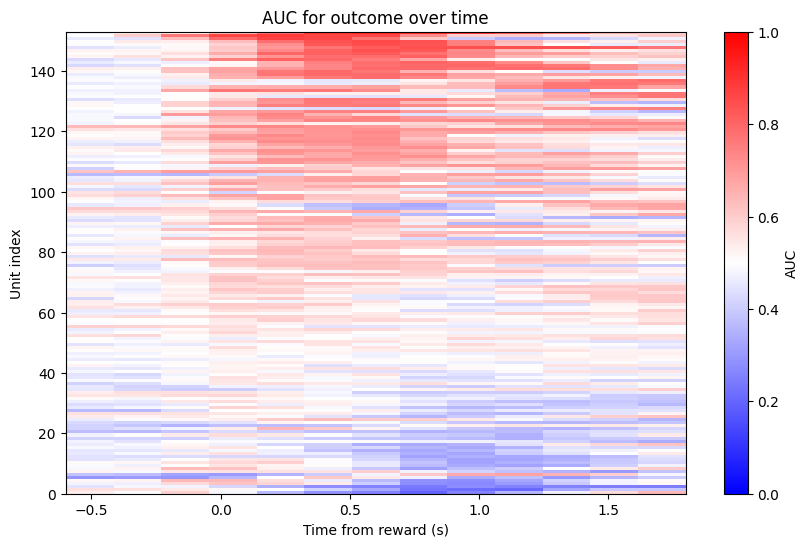

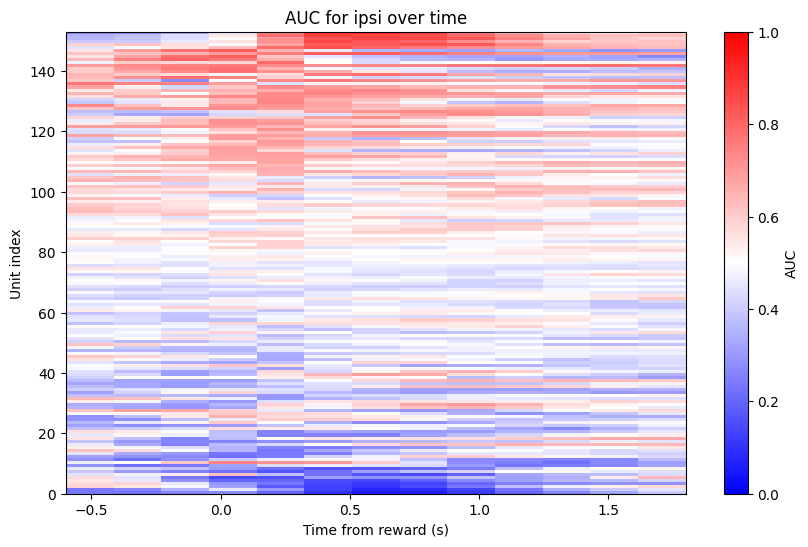

In [25]:
# Define custom colormap: white at 0, blue midrange, red at 1
custom_cmap = LinearSegmentedColormap.from_list(
    'blue_white_red', [(0.0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)

auc_mat = np.array(auc_mat)
auc_max = np.array(auc_max)
auc_max_ind = np.array(auc_max_ind)
for label_ind, label in enumerate(labels):
    plt.figure(figsize=(10, 6))
    sort_ind = np.argsort(auc_max[:, label_ind], axis=0)
    plt.imshow(auc_mat[sort_ind, :, label_ind], aspect='auto', origin='lower', 
               extent=[slide_times_auc[0], slide_times_auc[-1], 0, len(combined_tagged_units_filtered)], 
               cmap=custom_cmap, vmin=0, vmax=1, interpolation='none')
    plt.colorbar(label='AUC')
    plt.title(f'AUC for {label} over time')
    plt.xlabel('Time from reward (s)')
    plt.ylabel('Unit index')
    plt.savefig(os.path.join(metrics_folder, f'AUC_{label}_{criteria_name}.pdf'), bbox_inches='tight')

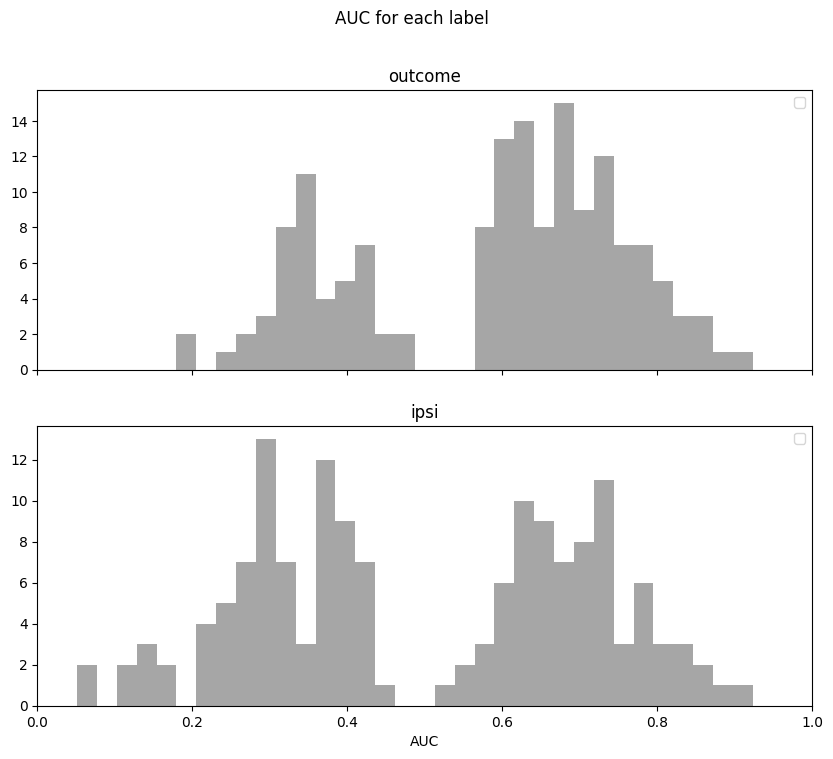

In [26]:
fig, axes = plt.subplots(len(labels), 1, figsize=(10, 8), sharex=True)
bins = np.linspace(0, 1, 40)
for label_ind, label in enumerate(labels):
    axes[label_ind].hist(auc_max[:, label_ind], bins=bins, color='gray', alpha=0.7, edgecolor='none')
    axes[label_ind].set_title(f'{label}')
    axes[label_ind].legend()
    axes[label_ind].set_xlim(0, 1)
plt.xlabel('AUC')
plt.suptitle('AUC for each label')
plt.savefig(os.path.join(metrics_folder, f'AUC_hist_{criteria_name}.pdf'), bbox_inches='tight')

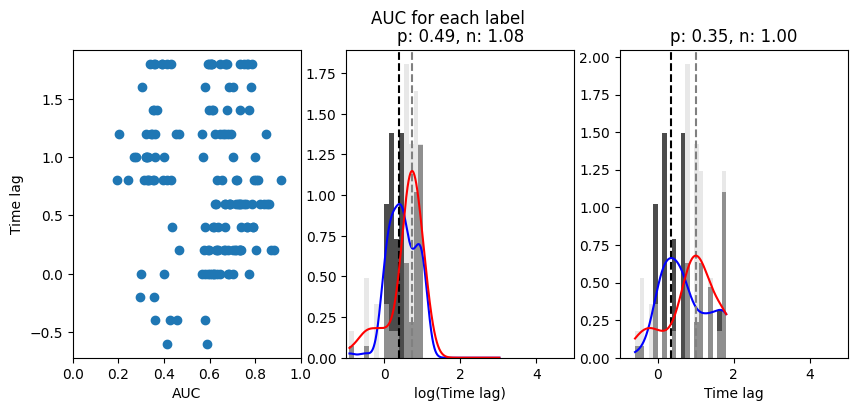

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=False, sharey=False)
bins = np.linspace(0, 1, 40)
for label_ind, label in enumerate(labels):
    if label=='outcome':

        axes[0].scatter(auc_max[:, label_ind], slide_times_auc[auc_max_ind[:, labels.index(label)]])
        axes[0].set_xlim(0, 1)
        axes[0].set_xlabel('AUC')
        axes[0].set_ylabel('Time lag')
        # bins = np.linspace(np.min(slide_times_auc[auc_max_ind[:, labels.index(label)]]), np.max(slide_times_auc[auc_max_ind[:, labels.index(label)]]), 40)
        bins = 15
        positive = slide_times_auc[auc_max_ind[:, labels.index(label)]][auc_max[:, label_ind]>=0.5]+1
        negative = slide_times_auc[auc_max_ind[:, labels.index(label)]][auc_max[:, label_ind]<0.5]+1
        axes[1].hist(np.log(positive[positive>=0]), bins=bins, color='k', alpha=0.7, edgecolor='none', density=True)
        kde = gaussian_kde(np.log(positive[positive>=0]))
        x_grid = np.linspace(min(np.log(positive)), max(np.log(positive))+2, 1000)
        pdf_values = kde(x_grid)
        mode_p = x_grid[np.argmax(pdf_values)]
        axes[1].axvline(mode_p, color='k', linestyle='--', label='Mode')
        axes[1].plot(x_grid, pdf_values, color='blue', label='Estimated PDF')
        axes[1].hist(np.log(negative[negative>=0]), bins=bins, color='lightgray', alpha=0.5, edgecolor='none', density=True)
        kde = gaussian_kde(np.log(negative[negative>=0]))
        pdf_values = kde(x_grid)
        mode_n = x_grid[np.argmax(pdf_values)]
        axes[1].axvline(mode_n, color='gray', linestyle='--', label='Mode')
        axes[1].plot(x_grid, pdf_values, color='red', label='Estimated PDF')
        axes[1].set_xlim(-1, 5)
        title = f'p: {np.exp(mode_p)-1:.2f}, n: {np.exp(mode_n)-1:.2f}'
        axes[1].set_title(title)
        axes[1].set_xlabel('log(Time lag)')

        bins = 20
        positive = slide_times_auc[auc_max_ind[:, labels.index(label)]][auc_max[:, label_ind]>=0.5]
        negative = slide_times_auc[auc_max_ind[:, labels.index(label)]][auc_max[:, label_ind]<0.5]
        axes[2].hist(positive, bins=bins, color='k', alpha=0.7, edgecolor='none', density=True)
        kde = gaussian_kde(positive)
        x_grid = np.linspace(min(positive), max(positive), 1000)
        pdf_values = kde(x_grid)
        mode_p = x_grid[np.argmax(pdf_values)]
        axes[2].axvline(mode_p, color='k', linestyle='--', label='Mode')
        axes[2].plot(x_grid, pdf_values, color='blue', label='Estimated  PDF')
        axes[2].hist(negative, bins=bins, color='lightgray', alpha=0.5, edgecolor='none', density=True)
        kde = gaussian_kde(negative)
        pdf_values = kde(x_grid)
        mode_n = x_grid[np.argmax(pdf_values)]
        axes[2].axvline(mode_n, color='gray', linestyle='--', label='Mode')
        axes[2].plot(x_grid, pdf_values, color='red', label='Estimated PDF')
        axes[2].set_xlim(-1, 5)
        title = f'p: {mode_p:.2f}, n: {mode_n:.2f}'
        axes[2].set_title(title)
        axes[2].set_xlabel('Time lag')
    

plt.suptitle('AUC for each label')
plt.savefig(os.path.join(metrics_folder, f'AUC_hist_{criteria_name}.pdf'), bbox_inches='tight')

In [28]:
# extract auROC 
mode_e_ind = np.argmin(np.abs(slide_times_auc-mode_p))
mode_l_ind = np.argmin(np.abs(slide_times_auc-mode_n))
auROC_e = auc_mat[:, mode_e_ind, labels.index('outcome')]
auROC_l = auc_mat[:, mode_l_ind, labels.index('outcome')]
auROC_max = np.full((auc_mat.shape[0],), np.nan, dtype=float)
for unit_ind in range(auc_mat.shape[0]):
    if np.abs(auROC_e[unit_ind]-0.5) > np.abs(auROC_l[unit_ind]-0.5):
        auROC_max[unit_ind] = auROC_e[unit_ind]
    else:
        auROC_max[unit_ind] = auROC_l[unit_ind]

# save window to .json
window_dict = {'late':mode_n, 'early':mode_p}
window_file = os.path.join(metrics_folder, f'auc_windows_{criteria_name}.json')
with open(window_file, 'w') as f:
    json.dump(window_dict, f)